In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
# Input layer
input_layer = tf.keras.layers.Input(shape=(512,))

# Hidden layer with ReLU activation
hidden_layer = tf.keras.layers.Dense(64, activation='relu')(input_layer)
hidden_layer = tf.keras.layers.Dense(32, activation='relu')(hidden_layer)

# Output layer with sigmoid activation for binary classification
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

# You can now use this 'model' object for training, evaluation, and prediction.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34945 (136.50 KB)
Trainable params: 34945 (136.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
cls_train = pd.read_csv('cls_train_ids_sample.csv')
cls_val = pd.read_csv('cls_val_ids_sample.csv')

In [7]:
train_x = pd.read_csv('cls_train_x.csv', header=None)
train_y = cls_train['fake'].to_numpy()

val_x = pd.read_csv('cls_val_x.csv', header=None)
val_y = cls_val['fake'].to_numpy()


In [8]:
train_x.shape, val_x.shape

((10000, 512), (5000, 512))

In [6]:
train_y.shape, val_y.shape

((10000,), (5000,))

In [9]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

neg, pos = np.bincount(train_y)
total = neg + pos
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

# Create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with the specified metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])


# Train the model with class weights and early stopping
history = model.fit(train_x, train_y, epochs=300, batch_size=128 , class_weight=class_weight, validation_data=(val_x, val_y), callbacks=[early_stopping])


{0: 0.5971575301564552, 1: 3.073140749846343}
Epoch 1/300
79/79 [==============================] - 2s 9ms/step - loss: 0.4086 - auc: 0.9308 - precision: 0.5765 - recall: 0.8869 - val_loss: 0.1439 - val_auc: 0.9849 - val_precision: 0.8080 - val_recall: 0.9698
Epoch 2/300
79/79 [==============================] - 0s 4ms/step - loss: 0.1020 - auc: 0.9891 - precision: 0.8530 - recall: 0.9846 - val_loss: 0.1374 - val_auc: 0.9878 - val_precision: 0.8362 - val_recall: 0.9899
Epoch 3/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0778 - auc: 0.9919 - precision: 0.8732 - recall: 0.9908 - val_loss: 0.1093 - val_auc: 0.9885 - val_precision: 0.8712 - val_recall: 0.9798
Epoch 4/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0621 - auc: 0.9943 - precision: 0.8871 - recall: 0.9945 - val_loss: 0.1135 - val_auc: 0.9888 - val_precision: 0.8710 - val_recall: 0.9861
Epoch 5/300
79/79 [==============================] - 0s 4ms/step - loss: 0.0519 - auc: 0.9959 - precis

157/157 [==============================] - 0s 1ms/step


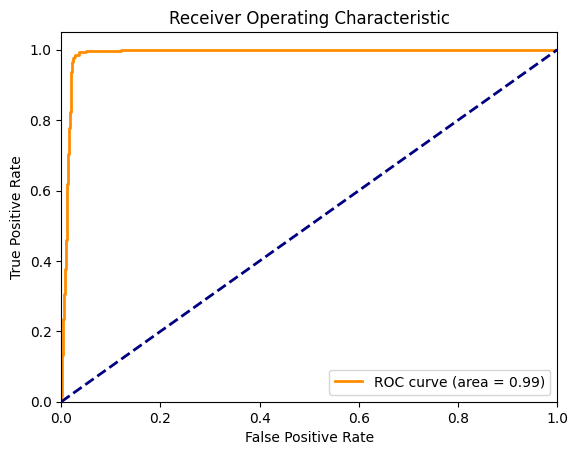

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
import tensorflow as tf

y_pred = model.predict(val_x)
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(val_y, y_pred)

# Calculate the ROC-AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC-AUC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [10]:
model.save('fake_classifier')

INFO:tensorflow:Assets written to: fake_classifier\assets


INFO:tensorflow:Assets written to: fake_classifier\assets
